In [1]:
import os
import argparse
import glob
import time
import cv2
import matplotlib
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from PIL import Image

In [2]:
def get_closestBS(y, y_space):
    if y < y_space[0] or y > y_space[-1]: # if y out of bounds of image return None
        return None
    
    low = 0
    high = len(y_space) - 1
    middle = int((low + high) / 2)
    while (low <= high):
        middle = int((low + high) / 2)
        _min = abs(y_space[middle] - y)
        
        if middle - 1 >= 0 and middle + 1 <= len(y_space) - 1:
            if abs(y_space[middle - 1] - y) < _min: # left case
                high = middle - 1
            
            elif abs(y_space[middle + 1] - y) < _min: # right case
                low = middle + 1
        
            else:
                return middle
            
        elif middle - 1 >= 0:
            if abs(y_space[middle - 1] - y) < _min: # left case
                high = middle - 1
            
            else:
                return middle
            
        elif middle + 1 <= len(y_space) - 1:
            if abs(y_space[middle + 1] - y) < _min: # right case
                low = middle + 1
        
            else:
                return middle
            
    return middle

In [3]:
def make_img(min_x, max_x, min_y, max_y, x_pixels, function):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.float32)
    
    for index, x in enumerate(x_space):
        y = function(x)
        closest = get_closestBS(y, y_space)
        if closest != None:
            y_index = len(y_space) - (1 + closest)
            img[y_index][index] = 255
    
    return img

## Making animations of graphs
___

In [4]:
import moviepy.editor as mvpy

In [5]:
def FunctionList(min_x, max_x, min_y, max_y, x_pixels, function, mod=1, width=1):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.int32)
    
    order = [] # list to keep track of order of images in the video we will create
    x_prev = None
    y_prev = None
    x_space_len = len(x_space)-1
    for index, x in enumerate(x_space):
        y = function(x) 
    
        if (index != 0) and (index!=x_space_len):
            closest = get_closestBS(y, y_space)
            closest_prev = get_closestBS(y_prev, y_space)
            if closest!=None and closest_prev!=None:
                y_index = len(y_space) - (1 + closest)
                y_index_prev = len(y_space) - (1 + closest_prev)
                cv2.line(img, (index-1, y_index_prev), (index, y_index), (255, 255, 255))
        
        if (index % mod) == 0: # take img every mod pixels
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img])) # write image to folder
            order.append("./data/img-{}.jpg".format(index)) # add image name to order list
        
        x_prev = x
        y_prev = y
    
    return order

def FunctionListDotted(min_x, max_x, min_y, max_y, x_pixels, function, mod=1, width=1):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.int32)
    
    order = [] # list to keep track of order of images in the video we will create
    for index, x in enumerate(x_space):
        if (index % mod) == 0: # take img every mod pixels
            y = function(x) 
            y_index = len(y_space) - (1 + get_closest(y, y_space))
            bottom = y_index - width
            top = y_index + width
            if bottom < 0:
                bottom = 0
            if top > img.shape[0]:
                top = img.shape[0]
            img[bottom:top, index] = 255
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img])) # write image to folder
            order.append("./data/img-{}.jpg".format(index)) # add image name to order list
    
    return order

def makeGraphAnimation(min_x, max_x, min_y, max_y, x_pixels, function, fps, fname, mod, width):
    d = []
    order = FunctionList(min_x, max_x, min_y, max_y, x_pixels, function, mod, width)
        
    clip = mvpy.ImageSequenceClip(order, fps=fps) # make clip object
    clip.write_videofile(fname, fps=fps) # write it to disk
    
def emptyDir(pathToDir, fileType="*"):
    for path in glob.glob("{}/{}".format(pathToDir, fileType)):
        os.unlink(path)

In [6]:
def makeGraphAnimation_multi(min_x, max_x, min_y, max_y, x_pixels, function, fps, fname, mod, width, color):
    d = []
    order = FunctionList_multi(min_x, max_x, min_y, max_y, x_pixels, function, mod, width, color)
        
    clip = mvpy.ImageSequenceClip(order, fps=fps) # make clip object
    clip.write_videofile(fname, fps=fps) # write it to disk
    
def FunctionList_multi(min_x, max_x, min_y, max_y, x_pixels, function, mod, width, color):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space), 3), dtype=np.int32)
    
    order = [] # list to keep track of order of images in the video we will create
    x_prev = np.zeros(len(color))
    y_prev = np.zeros(len(color))
    x_space_len = len(x_space)-1
    for index, x in enumerate(x_space):
        for index2, tup in enumerate(zip(function, color)):
            function_, color_ = tup
            y = function_(x) 

            if (index != 0) and (index!=x_space_len):
                closest = get_closestBS(y, y_space)
                closest_prev = get_closestBS(y_prev[index2], y_space)
                if closest!=None and closest_prev!=None:
                    y_index = len(y_space) - (1 + closest)
                    y_index_prev = len(y_space) - (1 + closest_prev)
                    cv2.line(img, (index-1, y_index_prev), (index, y_index), color_)

            if (index % mod) == 0: # take img every mod pixels
                cv2.imwrite("./data/img-{}.jpg".format(index), img) # write image to folder
                order.append("./data/img-{}.jpg".format(index)) # add image name to order list

            x_prev[index2] = x
            y_prev[index2] = y
    
    return order

In [47]:
makeGraphAnimation_multi(-2, 2, -1.1, 1.1, 3000, [lambda x: np.sin(x), lambda x: np.cos(x)], 100, "doublewave.mp4", [(40, 130, 255), (255, 130, 40)], 1, 0)

Moviepy - Building video doublewave.mp4.
Moviepy - Writing video doublewave.mp4



Moviepy - Done !
Moviepy - video ready doublewave.mp4


## Making animations of parametric functions
___

In [7]:
def getX(radius, angle):
    return np.cos(angle)*radius

def getY(radius, angle):
    return np.sin(angle)*radius

def timeImageMakerPolar(width, height, radius_function, angle_function, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        r_t = radius_function(t)
        a_t = angle_function(t)
        x_t = getX(r_t, a_t)
        y_t = getY(r_t, a_t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order

def timeImageMakerCart(width, height, X_function, Y_function, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        x_t = X_function(t)
        y_t = Y_function(t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order

def timeImageMakerFourier(width, height, radius_function, T, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        r_t = radius_function(t)
        a_t = 2*t*np.pi/T
        x_t = getX(r_t, a_t)
        y_t = getY(r_t, a_t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order
    
def timeAnimation(width, height, radius_function, angle_function, time, fps, mod, fname):
    #order = timeImageMaker(width, height, radius_function, angle_function, time, fps, mod)
    order = timeImageMakerFourier(width, height, radius_function, 2.3, time, fps, mod)
    
    clip = mvpy.ImageSequenceClip(order, fps=fps)

    clip.write_videofile(fname, fps=fps)

In [27]:
timeAnimation(1000, 1000, lambda x: 350*np.sin(x)*np.cos(3*x -4), lambda x: x*0.6, 30, 150, 1, "fourier.mp4")

Moviepy - Building video fourier.mp4.
Moviepy - Writing video fourier.mp4



Moviepy - Done !
Moviepy - video ready fourier.mp4


## Making animations of functions with a single parameter
___

In [8]:
def FunctionChange(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time, color):
    order = []
    p_space = np.linspace(p_min, p_max, int(time*fps))
    for index, p in enumerate(p_space):
        make_img_param(min_x, max_x, min_y, max_y, x_pixels, function, p, index, color)
        order.append("./data/img-{}.jpg".format(index))
        
    return order

def Panimation(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, fname, time, color=(255, 255, 255)):
    order = FunctionChange(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time, color)
    
    clip = mvpy.ImageSequenceClip(order, fps=fps)
    clip.write_videofile(fname, fps=fps)
    
    return clip

In [9]:
def make_img_param(min_x, max_x, min_y, max_y, x_pixels, function, parameter, i, color):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space), 3), dtype=np.int32)
    prev_x, prev_y = None, None
    for index, x in enumerate(x_space):
        y = function(parameter, x)
        if (index != 0) and (index!=len(x_space)-1):
                closest = get_closestBS(y, y_space)
                closest_prev = get_closestBS(prev_y, y_space)
                if closest!=None and closest_prev!=None:
                    y_index = len(y_space) - (1 + closest)
                    y_index_prev = len(y_space) - (1 + closest_prev)
                    cv2.line(img, (index-1, y_index_prev), (index, y_index), color)
        prev_x = x
        prev_y = y
        
    cv2.imwrite("./data/img-{}.jpg".format(i), img)
    
def make_img_param_multi(min_x, max_x, min_y, max_y, x_pixels, function, parameter, i, color):
    assert len(function) == len(color)
    
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space), 3), dtype=np.int32)
    prev_x, prev_y = np.zeros(len(color)), np.zeros(len(color))
    for index, x in enumerate(x_space):
        for index2, tup in enumerate(zip(function, color)):
            function_, color_ = tup
            y = function_(parameter, x)
            if (index != 0) and (index!=len(x_space)-1):
                    closest = get_closestBS(y, y_space)
                    closest_prev = get_closestBS(prev_y[index2], y_space)
                    if closest!=None and closest_prev!=None:
                        y_index = len(y_space) - (1 + closest)
                        y_index_prev = len(y_space) - (1 + closest_prev)
                        cv2.line(img, (index-1, y_index_prev), (index, y_index), color_)
            prev_x[index2] = x
            prev_y[index2] = y
        
    cv2.imwrite("./data/img-{}.jpg".format(i), img)

In [10]:
def FunctionChange_multi(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time, color):
    order = []
    p_space = np.linspace(p_min, p_max, int(time*fps))
    for index, p in enumerate(p_space):
        make_img_param_multi(min_x, max_x, min_y, max_y, x_pixels, function, p, index, color)
        order.append("./data/img-{}.jpg".format(index))
        
    return order

def Panimation_multi(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, fname, time, color=(255, 255, 255)):
    order = FunctionChange_multi(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time, color)
    
    clip = mvpy.ImageSequenceClip(order, fps=fps)
    clip.write_videofile(fname, fps=fps)
    
    return clip

In [38]:
clip = Panimation_multi(-6, 6, -6, 6, 1500, [lambda p, x: np.sin(p*x), lambda p, x: np.cos(p*x)], -5, 5, 150, "parameter3.mp4", 4, [(40, 130, 255), (255, 130, 40)])

Moviepy - Building video parameter3.mp4.
Moviepy - Writing video parameter3.mp4



Moviepy - Done !
Moviepy - video ready parameter3.mp4


In [ ]:
makeGraphAnimation_multi(-2, 2, -4, 4, 1000, [lambda x: c[x], lambda x: d[x]], 150, "polytest.mp4", 1, 0, [(40, 130, 255), (255, 130, 40)])

## Polynomial class 
___
Represents a function, supports basic derivative operations. A polynomial object  $Z$ can be used in the lambda expression as a function in the following manner: `lambda x:`  $Z$`[x]`

In [11]:
class Polynomial:
    powers = {}
    
    def __init__(self, powers_):
        self.powers = powers_
        
        for key, value in self.powers.items(): 
            type_ = type(self.powers[key])
            if type_ != list:
                self.powers[key] = [self.powers[key]]
        
    def AddPower(self, n, val):
        if n in powers.keys():
            self.powers[n] += val
        else:
            self.powers[n] = val
            
    def SetPower(self, n, val):
        if n in self.powers.keys():
            self.powers[n].append(val)
        else:
            self.powers[n] = [val]
        
    def getPower(self):
        return self.powers
        
    def getPowerAt(self, n):
        return self.powers[n]
    
    def GetDerivative(self):
        der = Polynomial({})
        for key in self.powers.keys():
            if key != 0:
                for value in self.powers[key]:
                    if type(value) == int or type(value) == float:
                        der.SetPower(key - 1, key*value)
                    else:
                        ### IF KEY == 1 THIS CAN BE MADE TO BE MORE EFFICIENT ###
                        poly = Polynomial({key - 1: value})
                        a = ConstPolynomial(poly, key)
                        b = MulPolynomial(a, value.GetDerivative())
                        der.SetPower(1, b)
                
        return der
    
    def GetIntegral(self):
        integral = Polynomial({})
        for key in self.powers.keys():
            if key != -1 and key != 0:
                for value in self.powers[key]:
                    if type(value) == int or type(value) == float:
                        der.SetPower(key + 1, value / key)
                    else:
                        bottom = Polynomial({-1 :value.GetIntegral()})
                        bottom = ConstPolynomial(bottom, 1.0 / key)
                        top = Polynomial({key + 1: value})
                        mulpoly = MulPolynomial(bottom, top)
                        der.SetPower(1, mul)
            elif key != 0: # case when key is -1
                pass
            else: # case when key is 0
                for value in self.powers[key]:
                    integral.SetPower(1, value)
    
    def __mul__(self, other):
        t = type(other)
        assert t == int or t == float, "Multiplication for this type is not supported"
        for key in self.powers.keys():
                self.powers[key] *= other
            
        
    def __rmul__(self, other):
        return self * other
    
    def __getitem__(self, x):
        sum_ = 0.0
        for key in self.powers.keys():
            for val in self.powers[key]:
                if type(val) == int or type(val) == float:
                    sum_ += val*x**key
                else:   
                    sum_ += val[x]**key
        
        return sum_
    
    def __str__(self):
        toReturn = ""
        ordered = sorted(self.powers.keys())
        length = len(ordered)
        for i in range(length):
            key = ordered[length - (i + 1)]
            if i == 0:
                toReturn += str(self.powers[key]) + "x^" + str(key)
            else:
                toReturn += " + " + str(self.powers[key]) + "x^" + str(key)
                
        return toReturn

In [12]:
class MulPolynomial:
    polynomial1 = None
    polynomial2 = None
    
    def __init__(self, poly1, poly2):
        self.polynomial1 = poly1
        self.polynomial2 = poly2
        
    def __getitem__(self, x):
        return self.polynomial1[x] * self.polynomial2[x]
    
    def GetDerivative(self):
        der1 = self.polynomial1.GetDerivative()
        der2 = self.polynomial2.GetDerivative()
        mul1 = MulPolynomial(self.polynomial1, der2)
        mul2 = MulPolynomial(self.polynomial2, der1)
        der = AddPolynomial(mul1, mul2)
        
        return der
    
    def GetIntegral(self):
        """TODO
        ###IMPLEMENT INTEGRATION BY PARTS###
        """
        return 0

In [13]:
class AddPolynomial:
    polynomial1 = None
    polynomial2 = None
    
    def __init__(self, poly1, poly2):
        self.polynomial1 = poly1
        self.polynomial2 = poly2
        
    def __getitem__(self, x):
        return self.polynomial1[x] + self.polynomial2[x]
    
    def GetDerivative(self):
        der1 = self.polynomial1.GetDerivative()
        der2 = self.polynomial2.GetDerivative()
        der = AddPolynomial(der1, der2)
        
    def GetIntegral(self):
        integral1 = self.polynomial1.GetIntegral()
        integral2 = self.polynomial2.GetIntegral()
        integral = AddPolynomial(integral1, integral2)
        
        return integral

In [14]:
class ConstPolynomial:
    polynomial = None
    scaleBy = 1
    
    def __init__(self, poly, const):
        self.polynomial = poly
        self.scaleBy = const
        
    def __getitem__(self, x):
        return self.scaleBy * self.polynomial[x]
    
    def GetDerivative(self):
        return ConstPolynomial(self.polynomial.GetDerivative(), self.scaleBy)
    
    def GetIntegral(self):
        return ConstPolynomial(self.polynomial.GetIntegral(), self.scaleBy)

## Testing Polynomial classes 
Here I'm attempting to take the derivative of $2x\sqrt{x^2 + 1}$ using the polynomial class. <br> 
The derivative is $\frac{4x^2 + 2}{\sqrt{x^2 + 1}}$, since this class doesn't store function the way we do, this check will be done through evaluation. <br>
Here is a table of values for $f(x)$ and $f`(x)$.

|$x$  | $f(x)$ | $f`(x)$ |
|:------------- | :------------- | :------------- |
|  1    | 2.828  | 4.242 |
|  2    | 8.944  | 8.049 |
|  3    | 18.973  | 12.016 |
|  4    | 32.984  | 16.007 |

In the next cell I will be constructing the function and getting it's derivative as well as testing how well it does on the samples above.

In [29]:
a = Polynomial({1: 2})
b = Polynomial({2: 1, 0: 1})
c = Polynomial({0.5: b})
d = MulPolynomial(a, c) # d is the function
e = d.GetDerivative() # e is it's derivative

In [30]:
f = e.GetIntegral()

In [15]:
print("Testing function: ", d[1], d[2], d[3], d[4])
print("Testing derivative: ", e[1], e[2], e[3], e[4])

Testing function:  2.8284271247461903 8.94427190999916 18.973665961010276 32.984845004941285
Testing derivative:  4.242640687119286 8.049844718999243 12.016655108639842 16.007351252397974


## Recursive trees
---

In [125]:
def RecursiveTreeHelper(img, X ,Y, angle, r, common_ratio, min_r, base_angle):
    r = r*common_ratio
    if r < min_r:
        return
    angle1 = angle + base_angle
    angle2 = angle - base_angle
    dx1 = int(r * np.sin(angle1))
    dy1 = int(r * np.cos(angle1))
    dx2 = int(r * np.sin(angle2))
    dy2 = int(r * np.cos(angle2))
    cv2.line(img, (X, Y), (X + dx1, Y - dy1), color=(255))
    cv2.line(img, (X, Y), (X + dx2, Y - dy2), color=(255))
    RecursiveTreeHelper(img, X + dx1, Y - dy1, angle1, r, common_ratio, min_r, base_angle)
    RecursiveTreeHelper(img, X + dx2, Y - dy2, angle2, r, common_ratio, min_r, base_angle)

def MakeRecursiveTree(width, height, angle, r, common_ratio, min_r, base_angle):
    img = np.zeros((height, width))
    cv2.line(img, (int(width/2), height), (int(width/2), height - r), color=(255))
    RecursiveTreeHelper(img, int(width/2), height - r, angle, r, common_ratio, min_r, base_angle)
    
    return img

In [136]:
img = MakeRecursiveTree(2000, 1000, 0, 200, 0.8, 10, 0.1*np.pi)

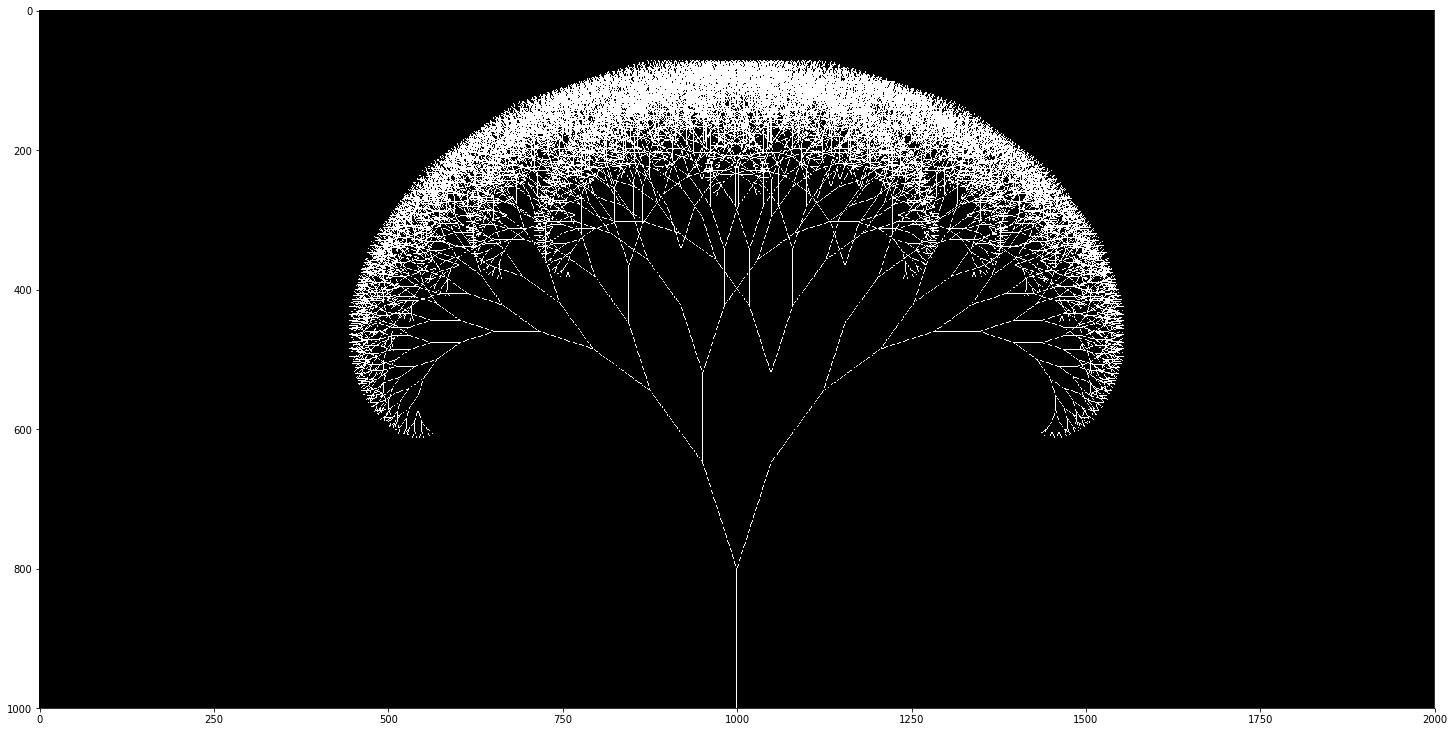

In [137]:
plt.figure(figsize=(25, 25))
plt.imshow(img, cmap="gray")